<a href="https://colab.research.google.com/github/KimGriezmann/Bigcontest_2021/blob/master/working_space_SeongGwan/Bigcontest_Barrel_def.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 빅콘테스트

2021.09.06

"파워배럴", "컨택배럴", "클러치배럴"을 각각 정의

### 1. **파워배럴**
- 기존 MLB정의는 타율 0.5이상, 장타율 1.5이상인데 "장타"만을 고려하는 배럴을 구상
- 순장타율은 장타율보다 장타에 대해 더 엄격한 기준을 적용함
- 따라서 **순장타율**을 기준으로 삼아 파워배럴을 정의해보고자 함

### 2. **컨택배럴**
- 빠른 속도로 내야를 빠져나가는 타구도 잘맞은 타구라고 생각함
- 직선타는 타구의 질 보다는 수비수의 수비능력, 위치에 좌우되는 경향이 있다고 생각해서 안타로 포함시킴
- 전체 타구 중 직선타와 1루타의 비율을 "**단타율**"로 정의해 컨택배럴의 기준으로 사용하고자 함

### 3. **클러치배럴**
- 승리에 크게 기여한 타구가 잘 맞은 타구라고 생각해 봄
- 해당 타석이 승리에 얼마나 기여했는지를 나타내는 **WPa**를 클러치배럴의 기준으로 사용하고자 함

In [ ]:
# 한글 폰트 다운로드(런타임 재시작 필요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

plt.rc('font', family='NanumBarunGothic') 

In [3]:
df = pd.read_csv('/content/drive/MyDrive/빅콘테스트/Bigcontest_df.csv', index_col=0)
df.head()

,DATE,PCODE,INN,HIT_VEL,HIT_ANG_VER,HIT_RESULT,PIT_VEL,PIT_ID,G_ID,RESULT_MG,order,NAME,POSITION,result,before,after,LEV,REa,WPs,WPe,WPa,P,pitcher,batter,vs
0,20180324,62797,1,131.50,42.7,플라이,149.59,180324_140436,20180324HHWO0,플라이,0.0,양성우,외,뜬공,1사 0:0,2사 0:0,0.62,-0.180,52.2,53.8,-0.016,1-2,로저스,양성우,넥센
1,20180324,76753,1,135.18,9.9,1루타,148.78,180324_140514,20180324HHWO0,1루타,0.0,송광민,내,안타,2사 0:0,2사 1루 0:0,0.40,0.134,53.8,52.6,0.012,0-0,로저스,송광민,넥센
2,20180324,71752,1,152.41,2.1,1루타,148.59,180324_140647,20180324HHWO0,1루타,0.0,김태균,내,안타,2사 1루 0:0,"2사 1,2루 0:0",0.79,0.215,52.6,50.6,0.020,0-2,로저스,김태균,넥센
3,20180324,62700,1,113.72,13.5,1루타,139.13,180324_140911,20180324HHWO0,1루타,0.0,하주석,내,안타,"2사 1,2루 0:0","2사 1,2루 1:0",1.62,1.000,50.6,40.7,0.099,2-1,로저스,하주석,넥센
4,20180324,78288,2,161.90,3.5,1루타,145.75,180324_142310,20180324HHWO0,1루타,0.0,최재훈,포,안타,무사 2루 1:0,"무사 1,3루 1:0",1.13,0.715,33.8,27.9,0.059,0-2,로저스,최재훈,넥센


# 파워배럴

In [4]:
print( '타구속도 범위 : {} km/h ~ {} km/h\n발사각도 범위 : {}º ~ {}º'.format(df['HIT_VEL'].min(), df['HIT_VEL'].max(), df['HIT_ANG_VER'].min(), df['HIT_ANG_VER'].max()) )

타구속도 범위 : 26.29 km/h ~ 210.13 km/h
발사각도 범위 : -68.1º ~ 89.8º


In [5]:
HA = {'1루타':'hit', '2루타':'hit', '홈런':'hit', '3루타':'hit', '플라이':'out', '땅볼':'out', '직선타':'out', '내야안타':'hit'}
SLG = {'1루타':'1루타', '2루타':'2루타', '홈런':'홈런', '3루타':'3루타', '플라이':'out', '땅볼':'out', '직선타':'out', '내야안타':'1루타'}

df['HA_result'] = df['RESULT_MG'].map(HA)
df['SLG_result'] = df['RESULT_MG'].map(SLG)

pw_barrel_vel=[]
pw_barrel_ang=[]
pw_barrel_SLG=[]
pw_barrel_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :             # 25, 30, 35, ... , 205, 210, 215 -> 타구속도
    for ang in range(-70, 90, 2) :                        # -70, -68, -66, ... , 86, 88, 90 -> 발사각도

        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]  # 해당 타구속도와 발사각도 범위 안의 타구들을 임시 데이터프레임으로 저장

        total_num = len(tmp)                              # 타율 계산을 위한 전체 타구 수 저장
        hit_num = list(tmp['HA_result']).count('hit')     # 임시 데이터프레임 중 hit의 개수 저장

        result_HA = hit_num / total_num if total_num != 0  else 0   # 타율 계산 (해당 타구가 0개라면 0으로 저장)

        b1_num = list(tmp['SLG_result']).count('1루타')     # 장타율 계산을 위한 루타별 개수 저장
        b2_num = list(tmp['SLG_result']).count('2루타')
        b3_num = list(tmp['SLG_result']).count('3루타')
        hr_num = list(tmp['SLG_result']).count('홈런')

        result_SLG = ((1*b1_num) + (2*b2_num) + (3*b3_num) + (4*hr_num)) / total_num if total_num != 0  else 0      # 장타율 계산 (해당 타구가 0개라면 0으로 저장)

        pure_SLG = result_SLG - result_HA       # 순장타율 계산 (타율 - 장타율)

        if (pure_SLG >= 0.5) & (total_num >= 10): # 순장타율이 0.5이상이고 전체 타구수가 10개 이상인 범위를 배럴로 정의
            pw_barrel_vel.append(vel)                # 배럴로 판정된 속도를 저장
            pw_barrel_ang.append(ang)                # 배럴로 판정된 각도를 저장
            pw_barrel_SLG.append(pure_SLG)

pw_barrel_df['VEL'] = pw_barrel_vel
pw_barrel_df['ANG'] = pw_barrel_ang
pw_barrel_df['pure_SLG'] = pw_barrel_SLG

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/38 [00:00<?, ?it/s]

In [6]:
def group_fuc(x):
    d={}
    d['min'] = x['ANG'].min()
    d['max'] = x['ANG'].max()
    return pd.Series(d)

# 타구속도별 각도의 최소값과 최대값을 저장

pw_barrel = pw_barrel_df.groupby(pw_barrel_df['VEL']).apply(group_fuc)
pw_barrel

,min,max
VEL,,
140,30,30
145,22,36
150,18,40
155,16,44
160,16,46
165,14,38
170,12,28


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


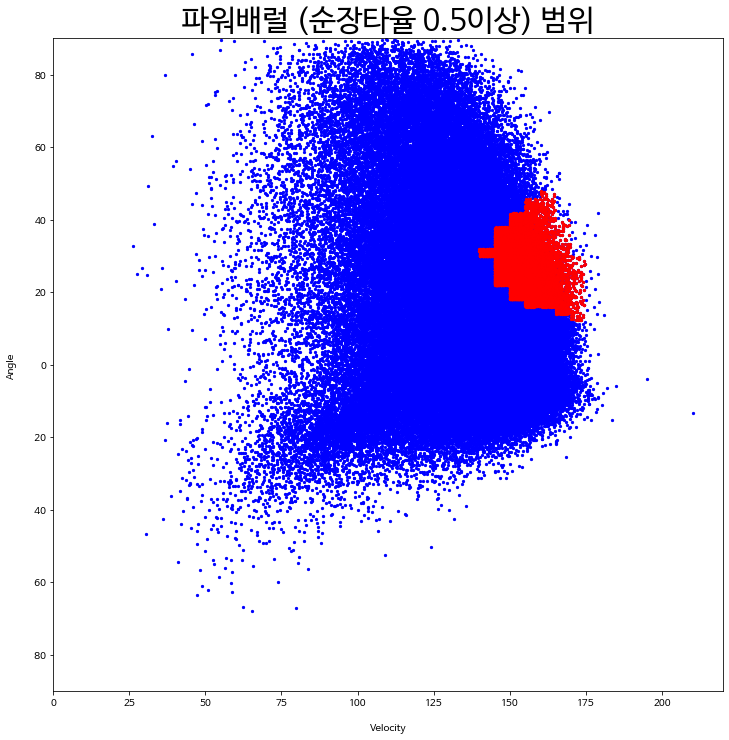

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('파워배럴 (순장타율 0.5이상) 범위', fontdict={'fontsize' : 30})
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b', s=5)

for i in range(pw_barrel.shape[0]):
    vel = pw_barrel.index[i]
    min_ang = pw_barrel.iloc[i][0]
    max_ang = pw_barrel.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r', s=5)

# 컨택배럴

In [8]:
HA_short = {'1루타':'hit', '2루타':'out', '홈런':'out', '3루타':'out', '플라이':'out', '땅볼':'out', '직선타':'hit', '내야안타':'out'}
df['HA_short_result'] = df['RESULT_MG'].map(HA_short)

ct_barrel_vel=[]
ct_barrel_ang=[]
ct_barrel_HA=[]
ct_barrel_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :
    for ang in range(-70, 90, 2) :
        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]
        total_num = len(tmp)
        hit_num = list(tmp['HA_short_result']).count('hit')

        short_HA = hit_num / total_num if total_num != 0  else 0

        if (short_HA >= 0.7) & (total_num >= 10):
            ct_barrel_vel.append(vel)
            ct_barrel_ang.append(ang)
            ct_barrel_HA.append(short_HA)

ct_barrel_df['VEL'] = ct_barrel_vel
ct_barrel_df['ANG'] = ct_barrel_ang
ct_barrel_df['short_HA'] = ct_barrel_HA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/38 [00:00<?, ?it/s]

In [10]:
def group_fuc(x):
    d={}
    d['min'] = x['ANG'].min()
    d['max'] = x['ANG'].max()
    return pd.Series(d)

ct_barrel = ct_barrel_df.groupby(ct_barrel_df['VEL']).apply(group_fuc)
ct_barrel

,min,max
VEL,,
90,28,30
95,16,36
100,12,34
105,12,26
110,10,22
115,10,20
120,8,18
125,8,16
130,6,14


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


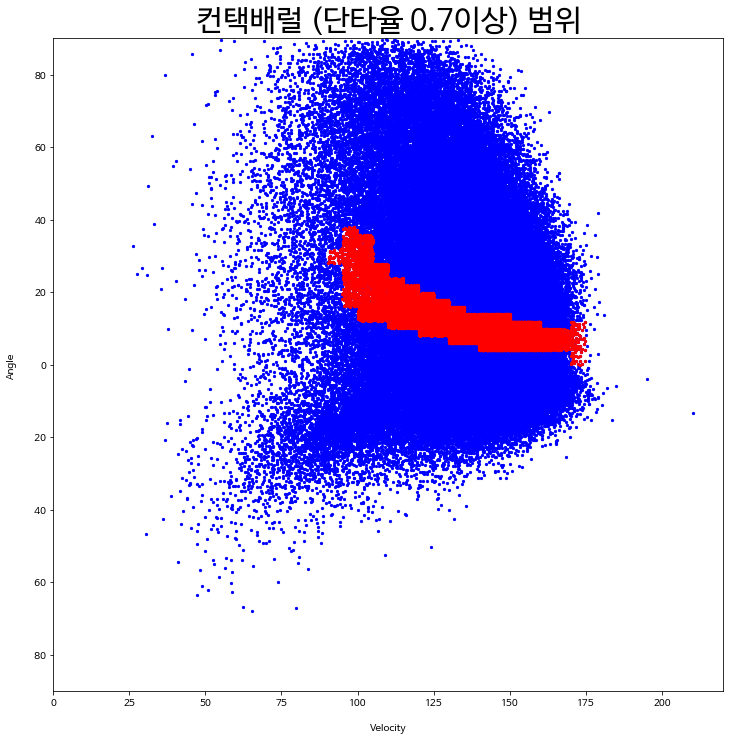

In [29]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('컨택배럴 (단타율 0.7이상) 범위', fontdict={'fontsize' : 30})
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b', s=5)

for i in range(ct_barrel.shape[0]):
    vel = ct_barrel.index[i]
    min_ang = ct_barrel.iloc[i][0]
    max_ang = ct_barrel.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r', s=5)

# 클러치배럴

In [18]:
WPa_mean = df['WPa'].groupby(df['RESULT_MG']).mean().to_frame()
WPa_mean

,WPa
RESULT_MG,
1루타,0.041086
2루타,0.065886
3루타,0.094707
내야안타,0.033245
땅볼,-0.025237
직선타,-0.027978
플라이,-0.022614
홈런,0.124316


In [25]:
crit_WPa = WPa_mean.loc[ ['1루타', '2루타', '3루타', '홈런'] ].mean()[0]
crit_WPa

0.08149899025923305

In [26]:
cl_barrel_vel=[]
cl_barrel_ang=[]
cl_barrel_wpa=[]
cl_barrel_df = pd.DataFrame()

for vel in tqdm_notebook(range(25, 215, 5)) :
    for ang in range(-70, 90, 2) :
        tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= ang) & (df['HIT_ANG_VER'] < ang+2)]
        total_num = len(tmp)
        wpa_mean = tmp['WPa'].mean()

        if (wpa_mean >= crit_WPa) & (total_num >= 10):
            cl_barrel_vel.append(vel)
            cl_barrel_ang.append(ang)
            cl_barrel_wpa.append(wpa_mean)


cl_barrel_df['VEL'] = cl_barrel_vel
cl_barrel_df['ANG'] = cl_barrel_ang
cl_barrel_df['WPa'] = cl_barrel_wpa

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/38 [00:00<?, ?it/s]

In [27]:
def group_fuc(x):
    d={}
    d['min'] = x['ANG'].min()
    d['max'] = x['ANG'].max()
    return pd.Series(d)

cl_barrel = cl_barrel_df.groupby(cl_barrel_df['VEL']).apply(group_fuc)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


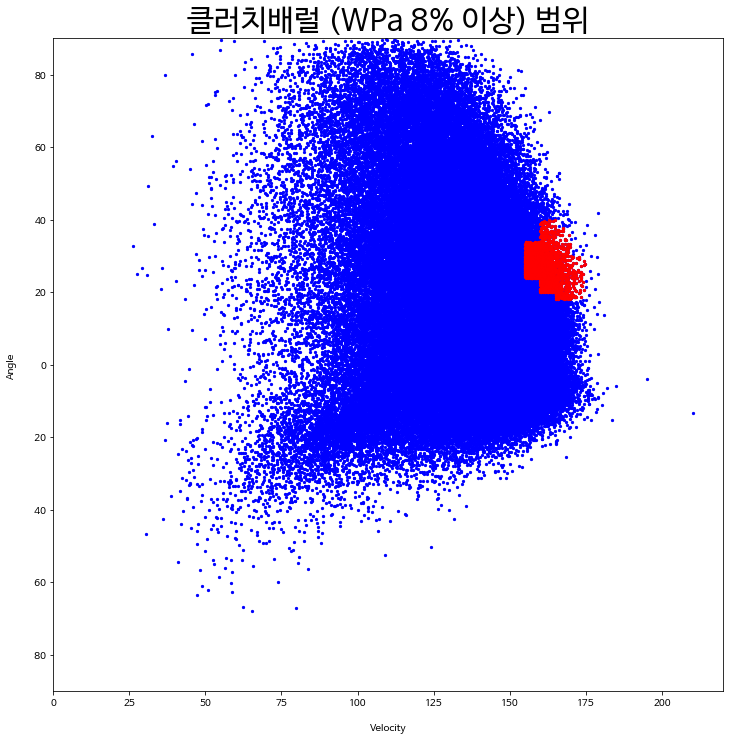

In [28]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title('클러치배럴 (WPa 8% 이상) 범위', fontdict={'fontsize' : 30})
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='b', s=5)

for i in range(cl_barrel.shape[0]):
    vel = cl_barrel.index[i]
    min_ang = cl_barrel.iloc[i][0]
    max_ang = cl_barrel.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r', s=5)

plt.show()

# 비교

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


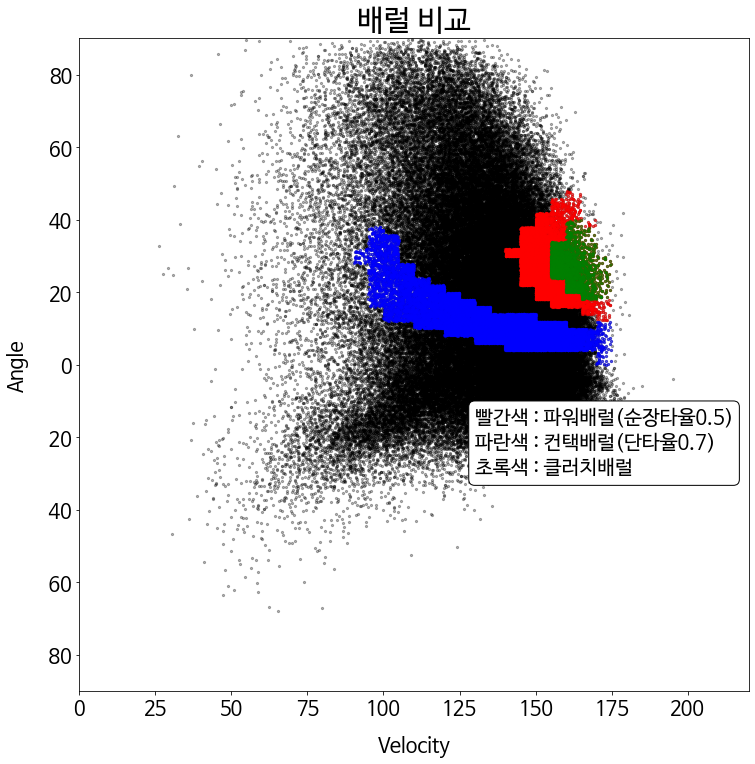

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
plt.rc('font', size=20)    
plt.rc('axes', labelsize=20) 
ax.set_title('배럴 비교', fontdict={'fontsize' : 30})
ax.set_xlabel('Velocity', labelpad=15)
ax.set_ylabel('Angle', labelpad=15)
ax.set_xlim([0, 220])
ax.set_ylim([-90, 90])
ax.scatter(df['HIT_VEL'], df['HIT_ANG_VER'], c='black', s=5, alpha=0.3)


for i in range(pw_barrel.shape[0]):
    vel = pw_barrel.index[i]
    min_ang = pw_barrel.iloc[i][0]
    max_ang = pw_barrel.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='r', s=5, alpha = 0.5, label='power')

for i in range(ct_barrel.shape[0]):
    vel = ct_barrel.index[i]
    min_ang = ct_barrel.iloc[i][0]
    max_ang = ct_barrel.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='b', s=5, alpha = 0.5, label='contact')

for i in range(cl_barrel.shape[0]):
    vel = cl_barrel.index[i]
    min_ang = cl_barrel.iloc[i][0]
    max_ang = cl_barrel.iloc[i][1]
    tmp = df[(df['HIT_VEL'] >= vel) & (df['HIT_VEL'] < vel+5) & (df['HIT_ANG_VER'] >= min_ang) & (df['HIT_ANG_VER'] < max_ang+2)]
    ax.scatter(tmp['HIT_VEL'], tmp['HIT_ANG_VER'], c='g', s=5, alpha = 0.5, label='clutch')

mybox={'facecolor':'w','edgecolor':'black','boxstyle':'round','alpha':1}
plt.text(130, -30, '빨간색 : 파워배럴(순장타율0.5)\n파란색 : 컨택배럴(단타율0.7)\n초록색 : 클러치배럴', bbox=mybox)
plt.savefig('/content/drive/MyDrive/빅콘테스트/순장타율0.5&단타율0.7배럴.png')
plt.show()